In [2]:
%matplotlib inline

### Dependency: `healpy`, `pymaster`, `xarray`, `pandas`, `seaborn`, `netCDF4`, `dask`

The following command should install all dependencies
```
conda install -c conda-forge xarray dask netCDF4 bottleneck namaster seaborn pandas healpy
```

In [3]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import pymaster as nmt
import glob,gc,os

In [4]:
# Information for TIGRESS synthetic maps
# dust polarization maps at 353 GHz can be downloaded at https://lambda.gsfc.nasa.gov/simulation/tb_tigress_data.cfm
data_folder = '../data/allsky_maps/'

# 9 observer positions
observers = ['x0y0z0','x-256y0z0','x256y0z0',
             'x0y-256z0','x-256y-256z0','x256y-256z0',
             'x0y256z0','x-256y256z0','x256y256z0']

# 350 snapshots to process
itimes=np.arange(300,650,dtype=int)

In [5]:
# pandas and xarray are used to store data
import pandas as pd
import xarray as xr

In [82]:
with xr.open_dataset('../data/all_cls.nc') as dset:
    avg=dset.sel(leff=slice(80,120)).mean(dim='leff')

In [161]:
ratio=xr.Dataset()
ratio['EEBB'] = avg['EE']/avg['BB']
ratio['rTE'] = avg['TE']/np.sqrt(avg['TT']*avg['EE'])
ratio['rTB'] = avg['TB']/np.sqrt(avg['TT']*avg['BB'])
ratio['rEB'] = avg['EB']/np.sqrt(avg['BB']*avg['EE'])

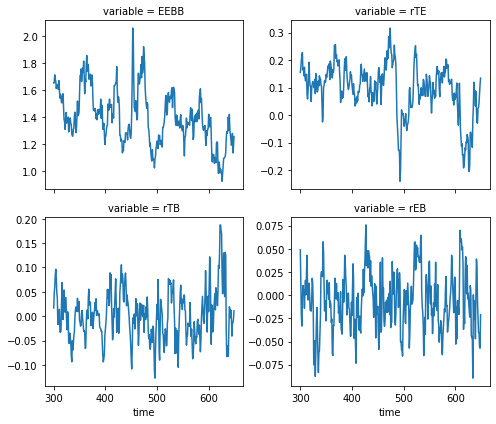

In [162]:
ratio.mean(dim='observer').to_array().plot(col='variable',sharey=False,col_wrap=2)

In [163]:
# convert to pandas dataframe to use seaborn pairplot
dlist=[]
for i,obs in enumerate(observers):
    df = ratio.sel(observer=i).to_array().to_pandas()
    ob=pd.Series(np.zeros_like(ratio.time)+i+1,index=ratio.time,name='observer',dtype=int)
    dlist.append(df.append(ob).T)

df=pd.concat(dlist,ignore_index=True)

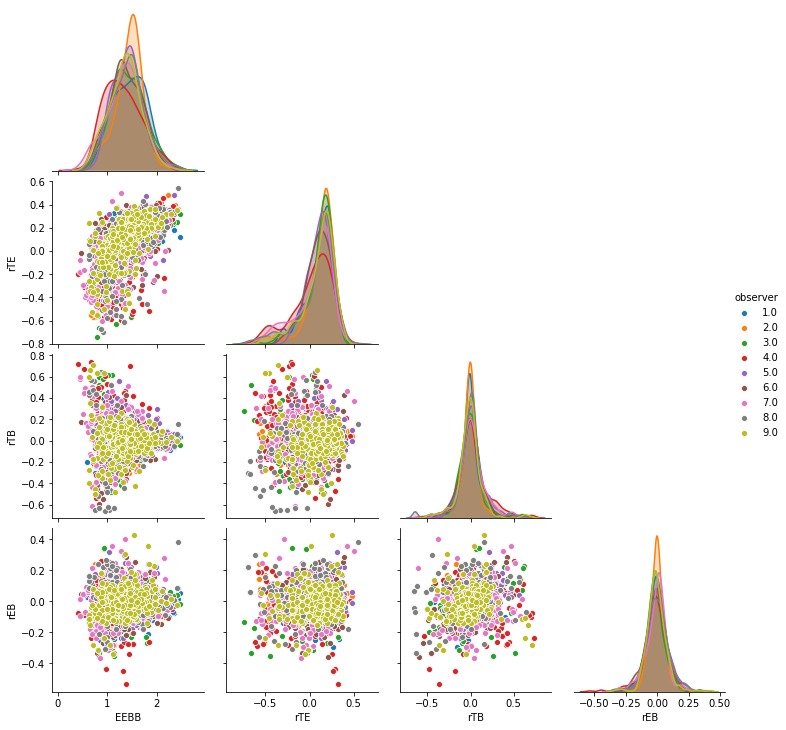

In [164]:
g = sns.pairplot(df.where((df.EEBB<2.5)),hue='observer',dropna=True,corner=True)
g.savefig('../figures/TB_not_TB/all_ratios_b30.png',bbox_inches='tight',dpi=200)

In [165]:
sns.pairplot(df.where((df.TE>0.1) & (df.EEBB<2.5)),hue='observer',dropna=True,corner=True)
g.savefig('../figures/TB_not_TB/rTEp01_ratios_b30.png',bbox_inches='tight',dpi=200)

AttributeError: 'DataFrame' object has no attribute 'TE'

In [ ]:
sns.pairplot(df.where((df.TE<-0.1) & (df.EEBB<2.5)),hue='observer',dropna=True,corner=True)
g.savefig('../figures/TB_not_TB/rTEn01_ratios_b30.png',bbox_inches='tight',dpi=200)